<a href="https://colab.research.google.com/github/chenny317/iat360_final/blob/main/IAT360_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import required libraries

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re, string

Load dataset

In [3]:
#importing the dataset
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

## Looking at the data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Here's a couple of examples of comments, one toxic, and one with no labels.

In [5]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [6]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

The length of the comments varies a lot.

In [7]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

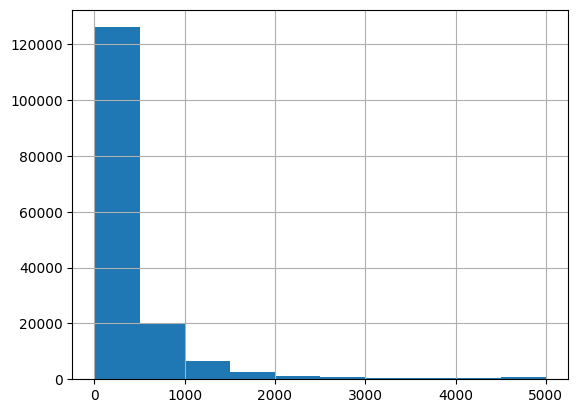

In [8]:
lens.hist();

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [9]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
len(train),len(test)

(159571, 153164)

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [11]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

<ipython-input-11-d2957acc749a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[COMMENT].fillna("unknown", inplace=True)


## Building the model

We'll start by creating a *bag of words* representation, as a *term document matrix*. We'll use ngrams, as suggested in the NBSVM paper.

Text Vectorization: Convert text into TF-IDF features

In [12]:
# Custom tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

Enhanced TF-IDF vectorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
vec = TfidfVectorizer(
    ngram_range=(1,2),  # Use unigrams and bigrams
    tokenizer=tokenize,
    min_df=3,
    max_df=0.9,
    strip_accents='unicode',
    use_idf=True,
    smooth_idf=True,
    sublinear_tf=True
)

Transform the data

In [15]:
X = vec.fit_transform(train["comment_text"])
y = train[label_cols].values
X_test = vec.transform(test["comment_text"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Naive Bayes Priors

In [16]:
def pr(y_i, y):
    p = X[y == y_i].sum(0)
    return (p + 1) / ((y == y_i).sum() + 1)

In [17]:
# Compute Naive Bayes priors for each class
nb_priors = []
for i, col in enumerate(label_cols):
    y_class = y[:, i]
    nb_priors.append(pr(1, y_class))


In [18]:
# Apply Naive Bayes priors to features
for i in range(len(label_cols)):
    X = X.multiply(nb_priors[i])

Split the dataset into train and validation sets

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


Convert sparse matrices to dense for TensorFlow compatibility

In [20]:
X_train = X_train.toarray()
X_valid = X_valid.toarray()

Build a neural network model

In [21]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_cols), activation='sigmoid')  # Output layer with one neuron per class
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the model

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=128,
                    epochs=10,
                    verbose=1)

Evaluate the model on validation data

In [1]:
y_pred = model.predict(X_valid)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

NameError: name 'model' is not defined

Calculate Accuracy and F1 Score for each class

In [23]:
accuracy_scores = []
f1_scores = []

for i, label in enumerate(TARGET_COLS):
    acc = accuracy_score(y_valid[:, i], y_pred_binary[:, i])
    f1 = f1_score(y_valid[:, i], y_pred_binary[:, i])
    accuracy_scores.append(acc)
    f1_scores.append(f1)
    print(f"Class: {label}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")

Class: toxic
  Accuracy: 0.9546
  F1 Score: 0.7468
Class: severe_toxic
  Accuracy: 0.9904
  F1 Score: 0.3598
Class: obscene
  Accuracy: 0.9776
  F1 Score: 0.7744
Class: threat
  Accuracy: 0.9981
  F1 Score: 0.4299
Class: insult
  Accuracy: 0.9682
  F1 Score: 0.6638
Class: identity_hate
  Accuracy: 0.9922
  F1 Score: 0.3873


Calculate and display average metrics

In [24]:
avg_accuracy = np.mean(accuracy_scores)
avg_f1 = np.mean(f1_scores)

print("\nOverall Metrics:")
print(f"  Average Accuracy: {avg_accuracy:.4f}")
print(f"  Average F1 Score: {avg_f1:.4f}")


Overall Metrics:
  Average Accuracy: 0.9802
  Average F1 Score: 0.5603


Confusion Matrix for each class

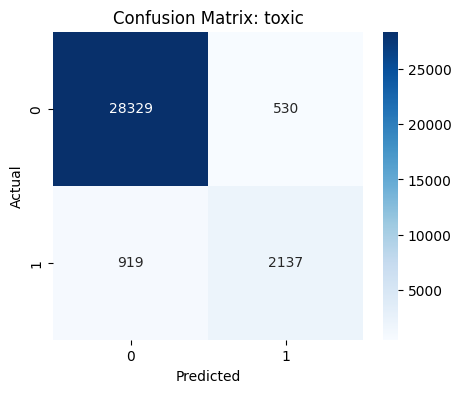

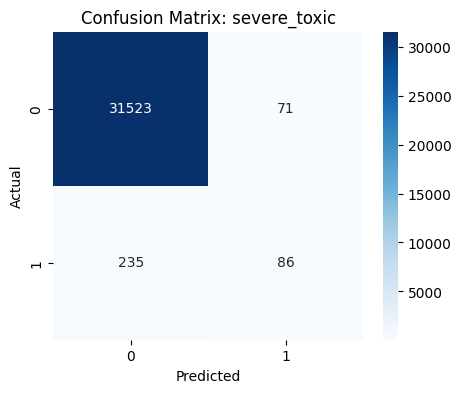

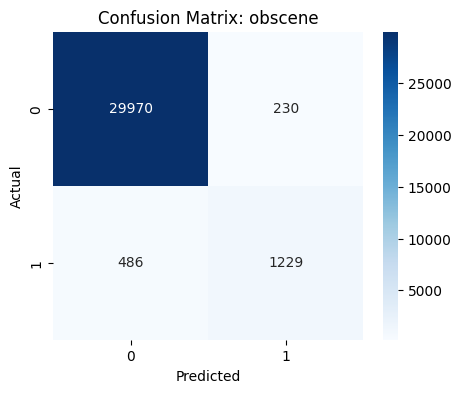

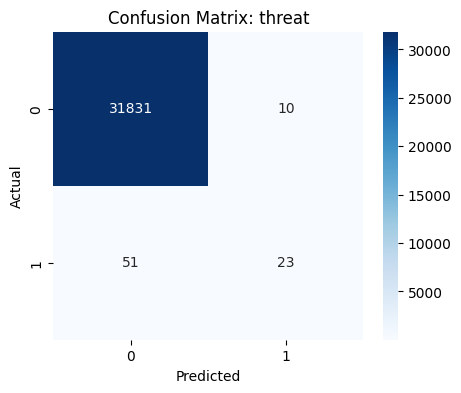

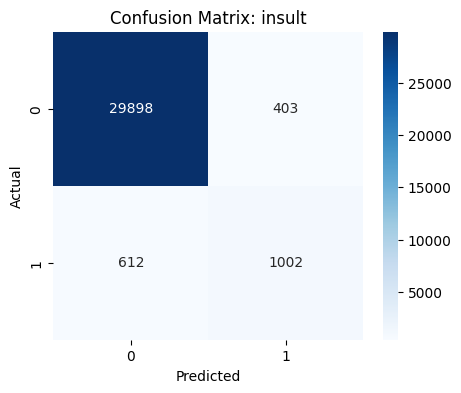

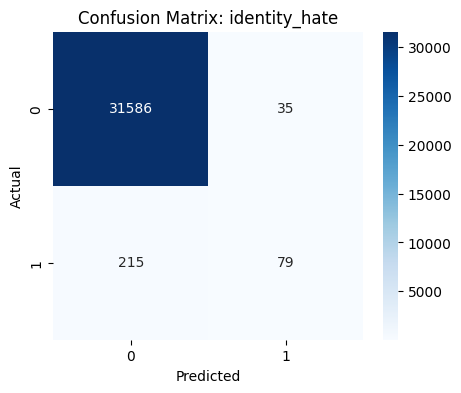

In [25]:
for i, label in enumerate(TARGET_COLS):
    cm = confusion_matrix(y_valid[:, i], y_pred_binary[:, i])
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Training Loss and Accuracy Graphs

In [35]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Loss

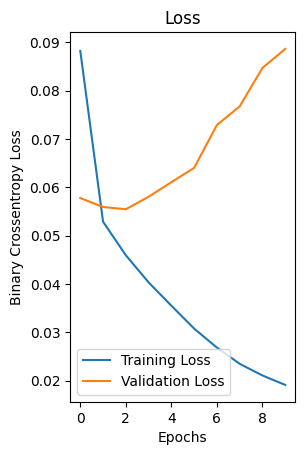

In [36]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()

plt.show()

Accuracy

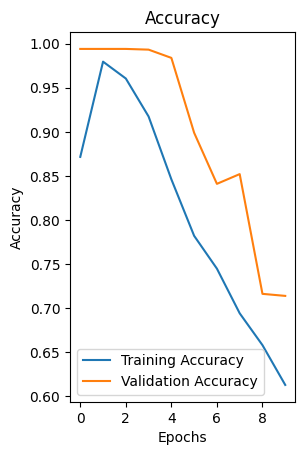

In [37]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()